# Optimizing the S&P 500

## Extra Discussion

### FINM 25000-2025

#### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA

In [3]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [4]:
LOADFILE = '../data/spx_returns_weekly.xlsx'
rets = pd.read_excel(LOADFILE, sheet_name='s&p500 rets').set_index('date')
FREQ = 52
rets = rets.iloc[:,::2]

In [5]:
GROSS_LIMIT = 4

In [6]:
Nt, Nk = rets.shape
ones = np.ones(Nt)

wts = pd.DataFrame(index = rets.columns,dtype=float) 
rp = pd.DataFrame(index = rets.index, dtype=float)

In [7]:
def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.1
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty

### Equally Weighted

In [8]:
wts['equal'] = 1/Nk

### Risk Parity

In [9]:
wts['parity'] = 1/rets.std()

### MV

In [10]:
wts['mv'] = LinearRegression(fit_intercept=False).fit(rets,ones).coef_

In [11]:
wts['nonnegative'] = LinearRegression(fit_intercept=False,positive=True).fit(rets,ones).coef_

### Ridge

In [12]:
wts['ridge'], penalty_ridge = penalized_reg_limit_gross(Ridge,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

### LASSO

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    wts['lasso'], penalty_lasso = penalized_reg_limit_gross(Lasso,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

## Performance

In [14]:
wts /= wts.sum()
rp = rets @ wts
performanceMetrics(rp,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
equal,0.1578,0.1834,0.8606,-0.1765,0.1706
parity,0.1515,0.1734,0.8737,-0.1664,0.1587
mv,1.0451,0.2080,5.0236,-0.0771,0.1445
nonnegative,0.3495,0.1837,1.9023,-0.1059,0.1094
ridge,0.5187,0.1953,2.6552,-0.0807,0.1143
lasso,0.6808,0.2322,2.9323,-0.0784,0.1325


In [15]:
tailMetrics(rp)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.3058,11.5118,-0.0340,-0.0596,-0.3553,2020-02-14,2020-03-20,2020-08-28,196 days
parity,-0.3617,11.1778,-0.0319,-0.0564,-0.3351,2020-02-14,2020-03-20,2020-08-28,196 days
mv,0.0861,0.5345,-0.0272,-0.0391,-0.1314,2020-08-21,2020-11-27,2021-01-22,154 days
nonnegative,-0.2163,2.4226,-0.0347,-0.0537,-0.2286,2020-02-21,2020-03-20,2020-05-22,91 days
ridge,-0.0583,0.7914,-0.0368,-0.0514,-0.1568,2020-02-21,2020-03-20,2020-04-17,56 days
lasso,0.2009,0.5679,-0.0364,-0.0533,-0.1763,2022-03-25,2022-05-20,2022-08-05,133 days


In [16]:
get_ols_metrics(rp['equal'],rp,annualization=FREQ)

,alpha,equal,r-squared,Treynor Ratio,Info Ratio
equal,0.0000,1.0000,1.0000,0.1578,None
parity,0.0026,0.9433,0.9957,0.1606,0.2301
mv,1.0144,0.1943,0.0293,5.3779,4.9493
nonnegative,0.2238,0.7962,0.6318,0.4389,2.0077
ridge,0.4142,0.6618,0.3860,0.7837,2.7062
lasso,0.5978,0.5263,0.1728,1.2936,2.8307


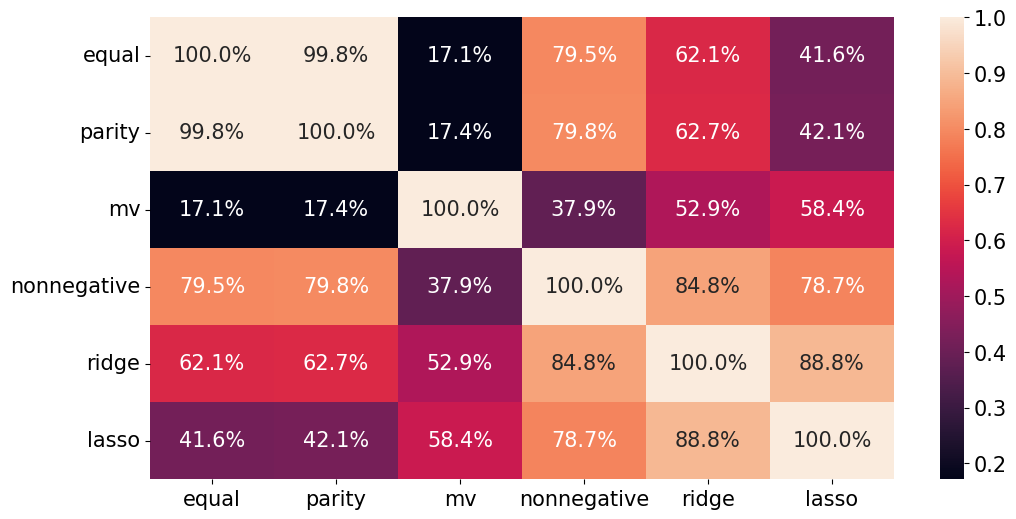

In [17]:
sns.heatmap(rp.corr(),annot=True,fmt='.1%');

## Understanding the Methods

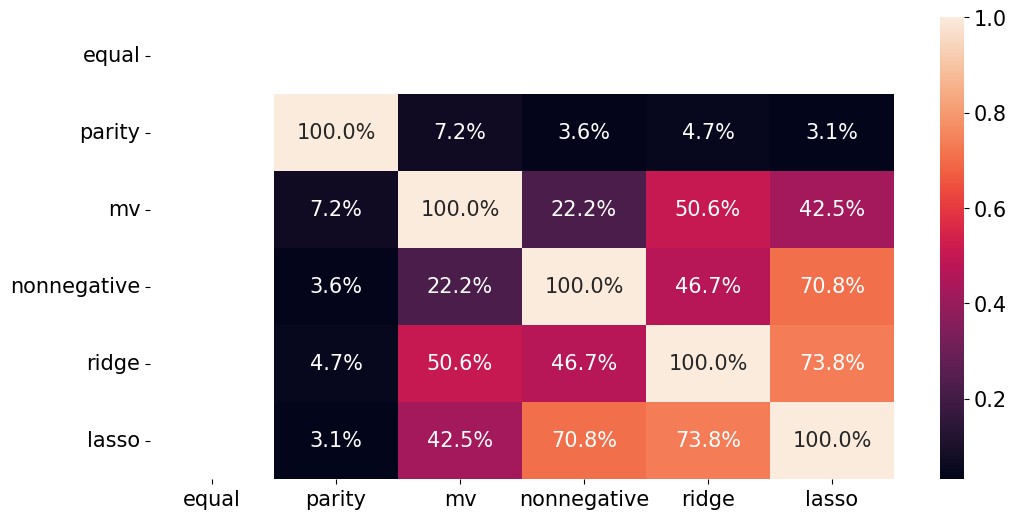

In [18]:
sns.heatmap(wts.corr(),annot=True,fmt='.1%');

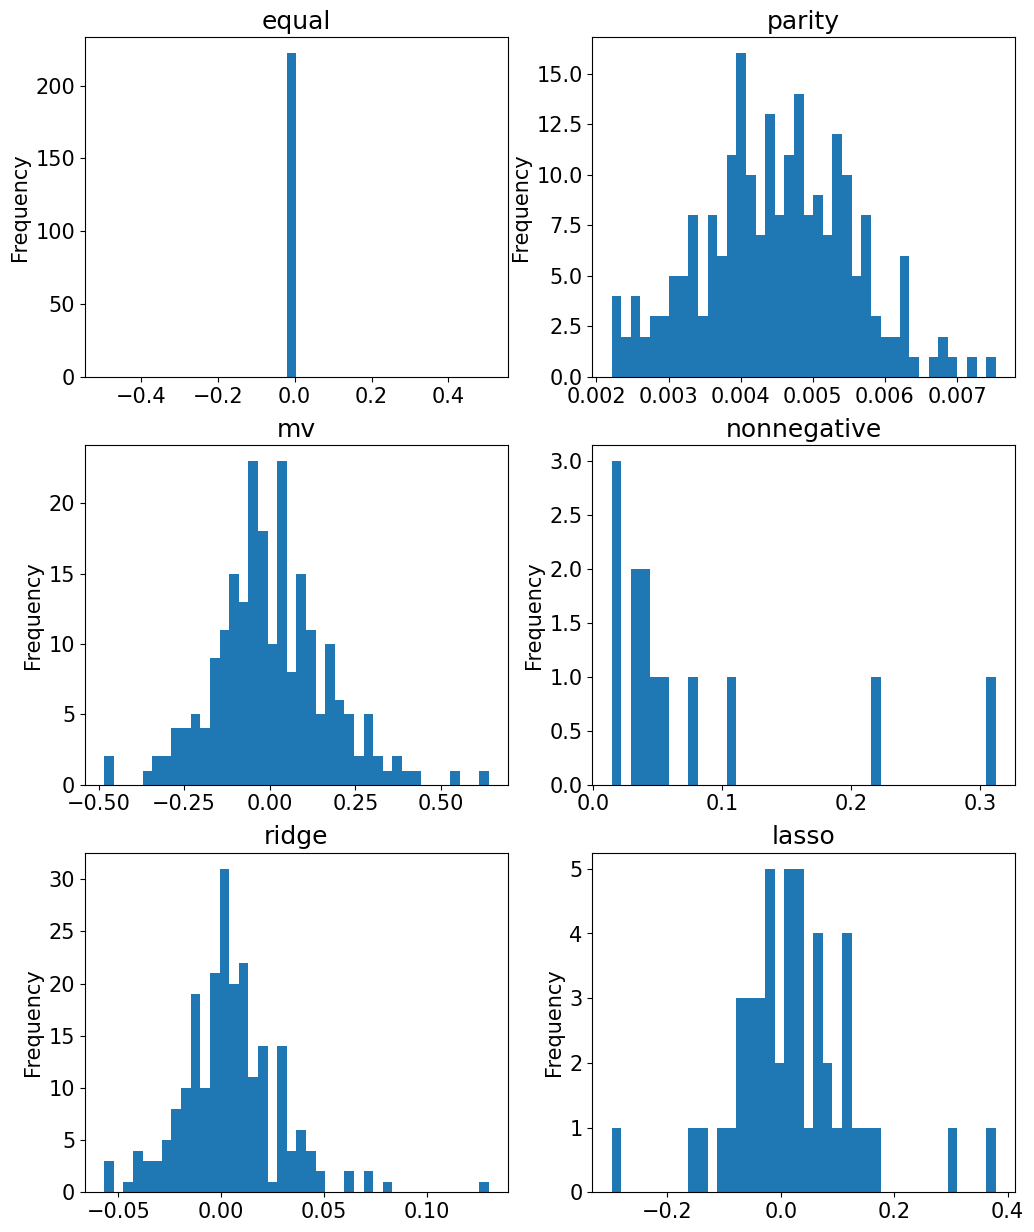

In [19]:
plotwts = wts.copy()
plotwts[plotwts.abs()<1e-4] = np.nan

fig, ax = plt.subplots(3,2,figsize=(12,15))
wmin = plotwts.min().min()
wmax = plotwts.max().max()
for i,method in enumerate(plotwts.columns):
    idplot = [int(np.floor(i/2)),i%2]
    plotwts[method].plot.hist(ax=ax[idplot[0],idplot[1]],bins=40,title=method)#,xlim=(wmin,wmax))

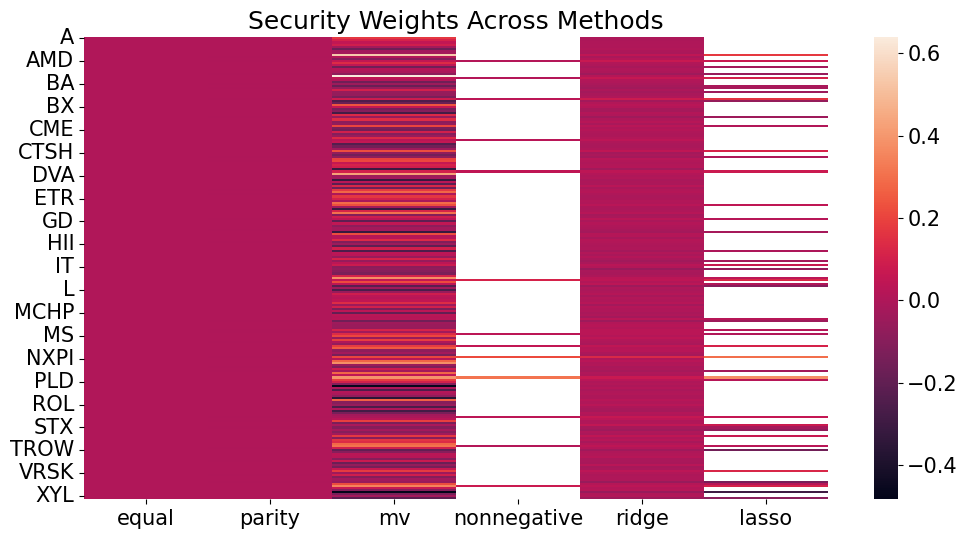

In [20]:
sns.heatmap(plotwts)
plt.title('Security Weights Across Methods')
plt.show()

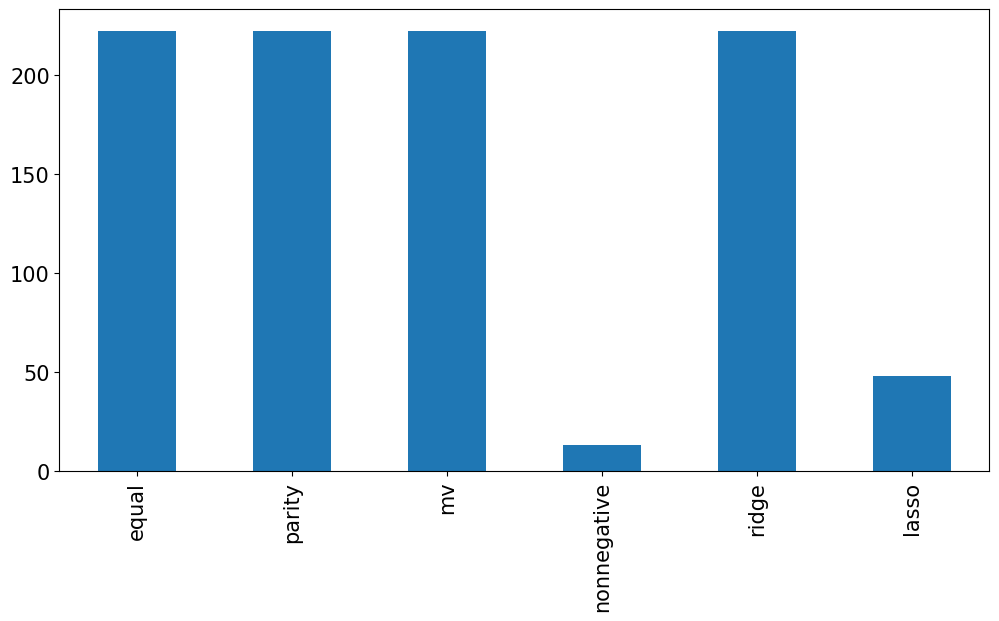

In [21]:
(wts.abs()>1e-4).sum().plot.bar();

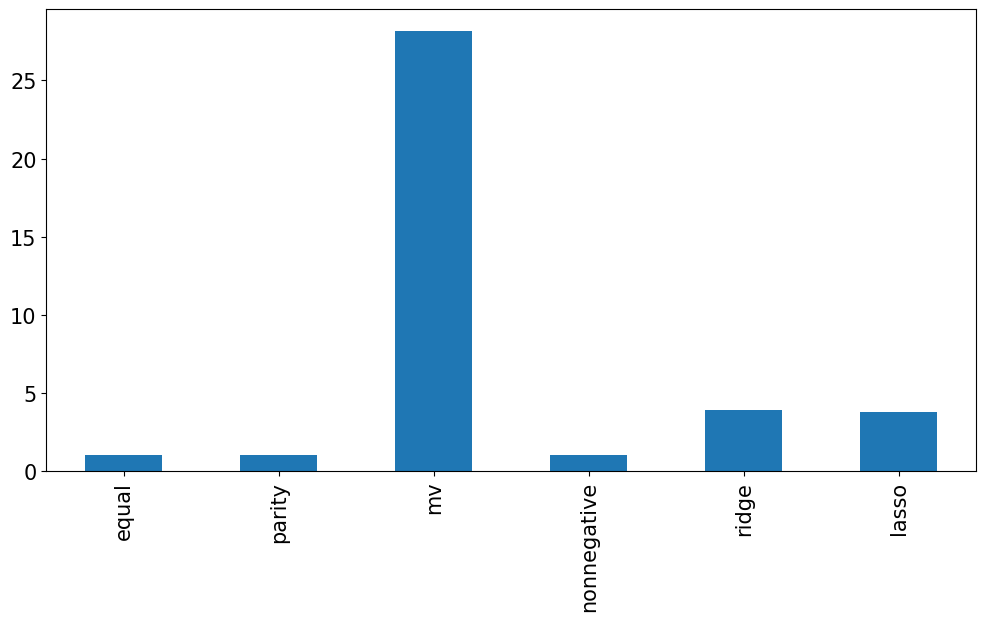

In [22]:
wts.abs().sum().plot.bar();

# Out of Sample

In [23]:
ADJUST_PENALTY = False
GROSS_LIMIT = 2

Nassets = Nk

minT = FREQ*4
methods = wts.columns

# initialize
wts_oos = pd.concat([pd.DataFrame(index=rets.index, columns=rets.columns)]*len(methods), keys=methods, axis=1)
equal_wts = np.ones(Nassets) / Nassets

In [24]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for t in wts_oos.index:    
        R = rets.loc[:t,:]
        y = np.ones(R.shape[0])

        if R.shape[0] >= minT:
            wts_oos.loc[t,'equal',] = equal_wts
            if 'SPY' in R.columns:
                wts_oos.loc[t,'SPY',] = 0
                wts_oos.loc[t,('SPY','SPY')] = 1

            wts_oos.loc[t,'mv',] = LinearRegression(fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'nonnegative',] = LinearRegression(positive=True, fit_intercept=False).fit(R,y).coef_    
            wts_oos.loc[t,'ridge',] = Ridge(alpha= penalty_ridge, fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'lasso',] = Lasso(alpha= penalty_lasso, fit_intercept=False).fit(R,y).coef_

            # dynamically adjust the penalty parameter
            # takes longer to run, brings gross leverage down
            if ADJUST_PENALTY:
                betas, penalty_ridge = penalized_reg_limit_gross(Ridge, R, y, limit=GROSS_LIMIT, fit_intercept=False)
                betas, penalty_lasso = penalized_reg_limit_gross(Lasso, R, y, limit=GROSS_LIMIT, fit_intercept=False)

for method in methods:
    div_factor = wts_oos[method].sum(axis=1)
    div_factor[div_factor==0] = 1
    wts_oos[method] = wts_oos[method].div(div_factor, axis='rows')

wts_oos_lag = wts_oos.shift(1)

CPU times: user 34min 28s, sys: 47min 2s, total: 1h 21min 31s
Wall time: 7min 37s


In [25]:
rets_port_oos = pd.DataFrame(index=rets.index, columns = methods)

for method in methods:    
    rets_port_oos[method] = (wts_oos_lag[method] * rets).sum(axis=1)

# do not count burn-in period
rets_port_oos.iloc[:minT,:] = None

In [26]:
rets_port_oos.drop(columns='parity',inplace=True)
display(performanceMetrics(rets_port_oos, annualization=12).style.format('{:.2%}'.format))
display(tailMetrics(rets_port_oos))
display(get_ols_metrics(rp['equal'], rets_port_oos,annualization=FREQ).style.format('{:.2%}'.format))

,Mean,Vol,Sharpe,Min,Max
equal,4.46%,10.31%,43.23%,-17.65%,17.06%
mv,17.53%,43.09%,40.67%,-45.98%,61.04%
nonnegative,4.78%,9.20%,51.97%,-12.87%,8.98%
ridge,4.10%,13.39%,30.65%,-18.74%,13.58%
lasso,6.28%,21.19%,29.62%,-38.67%,20.22%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.2518,9.9839,-0.0341,-0.0680,-0.3553,2020-02-14,2020-03-20,2020-08-28,196 days
mv,0.5527,3.1827,-0.1659,-0.2450,-0.8452,2020-11-06,2023-01-27,NaT,NaT
nonnegative,-0.6100,3.5031,-0.0389,-0.0595,-0.3130,2021-12-31,2022-10-14,2023-12-22,721 days
ridge,-0.6556,3.4773,-0.0578,-0.0935,-0.3677,2020-11-06,2022-10-14,2024-02-09,1190 days
lasso,-0.9896,6.9626,-0.0847,-0.1458,-0.5565,2020-11-06,2023-01-06,2024-05-24,1295 days


TypeError: unsupported format string passed to NoneType.__format__

In [27]:
wts_all = wts_oos.unstack().groupby(level=(0,2))
wts_all_diff = wts_oos.diff().unstack().groupby(level=(0,2))

gross_leverage = wts_all.apply(lambda x: sum(abs(x))).unstack(level=0)
turnover = wts_all_diff.apply(lambda x: sum(abs(x))).unstack(level=0)
num_positions = wts_all.apply(lambda x: sum(abs(x)>0)).unstack(level=0)
max_wt = wts_all.apply(lambda x: max(x)).unstack(level=0)
min_wt = wts_all.apply(lambda x: min(x)).unstack(level=0)

dates_active = (rets.index[minT],rets.index[-1])

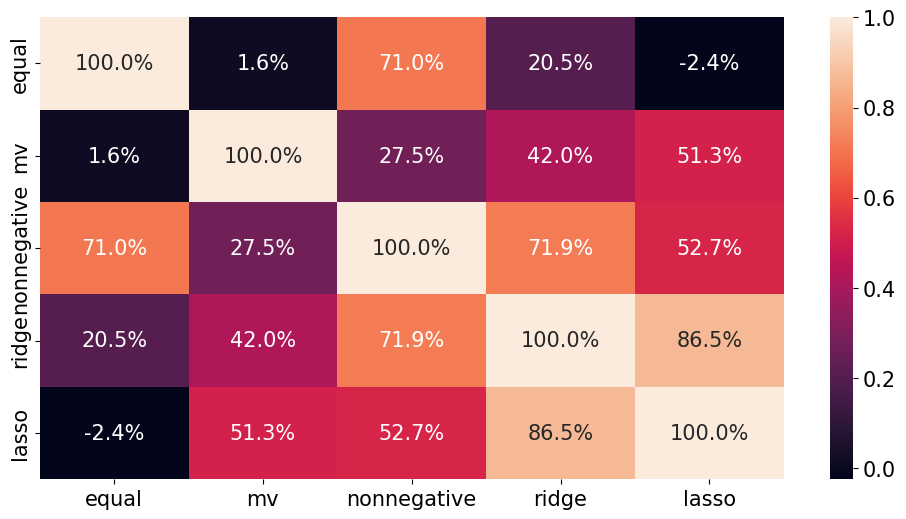

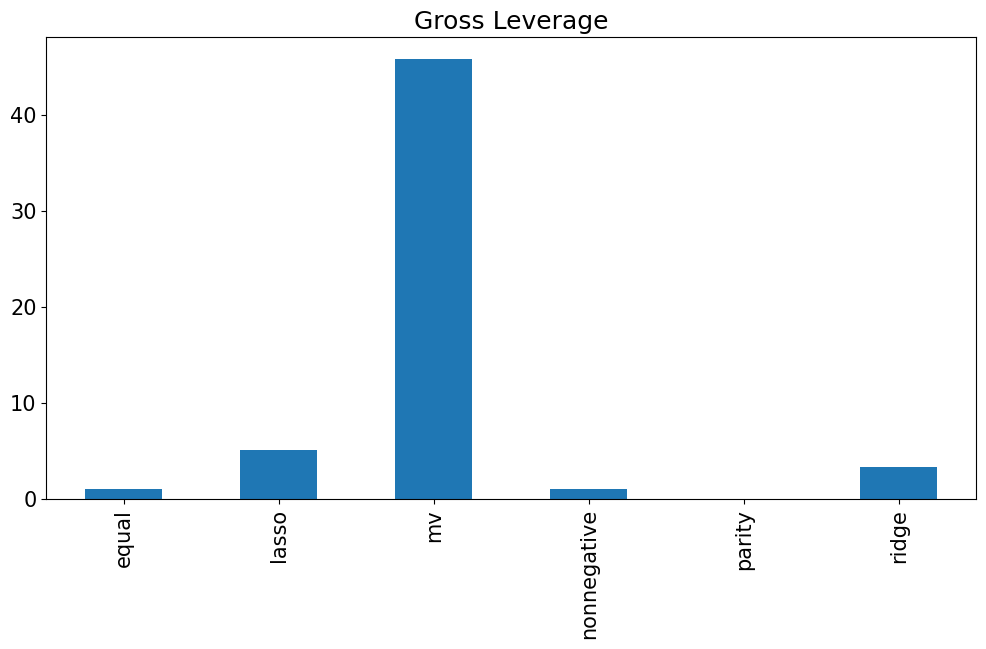

In [28]:
sns.heatmap(rets_port_oos.corr(),annot=True,fmt='.1%')
plt.show()
gross_leverage.mean().plot.bar(title='Gross Leverage');

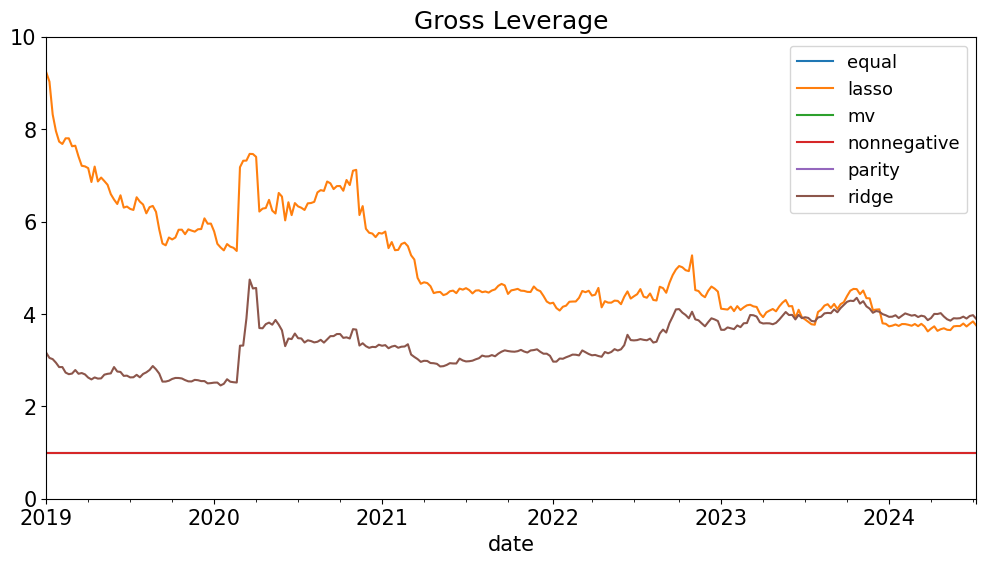

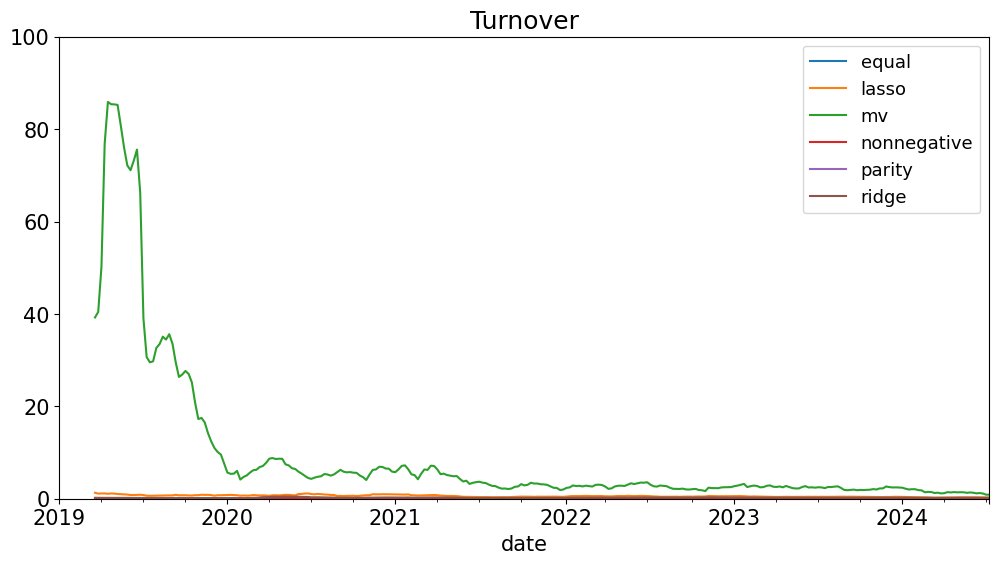

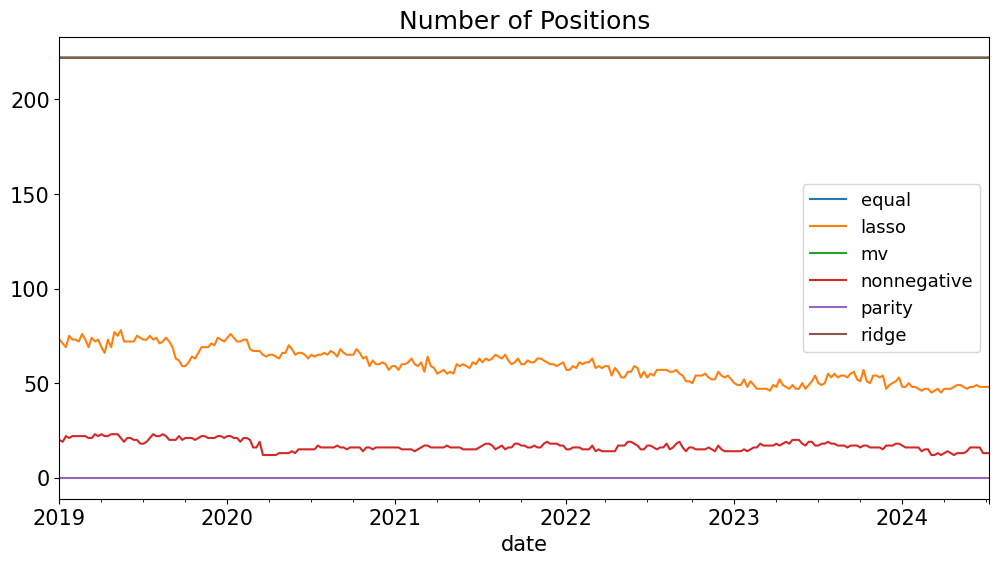

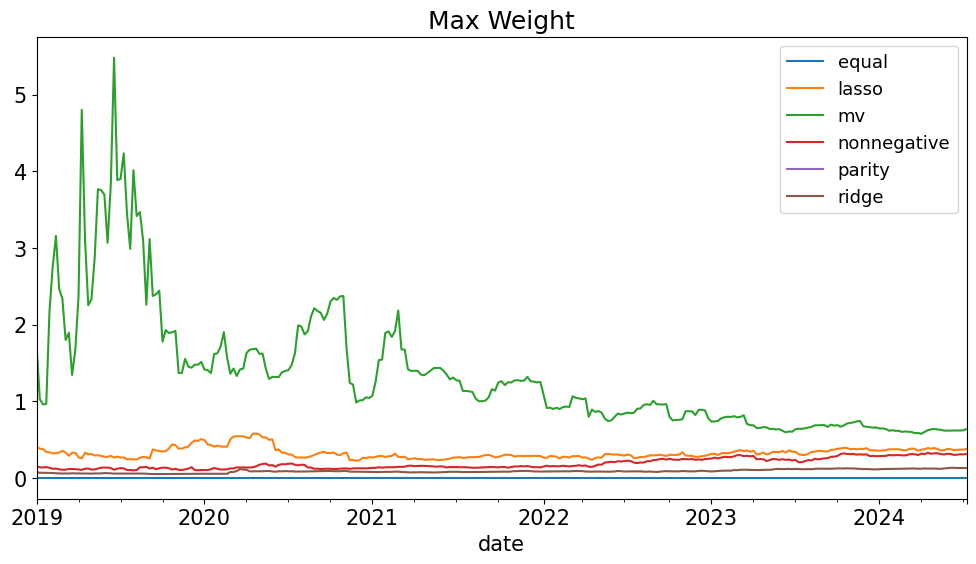

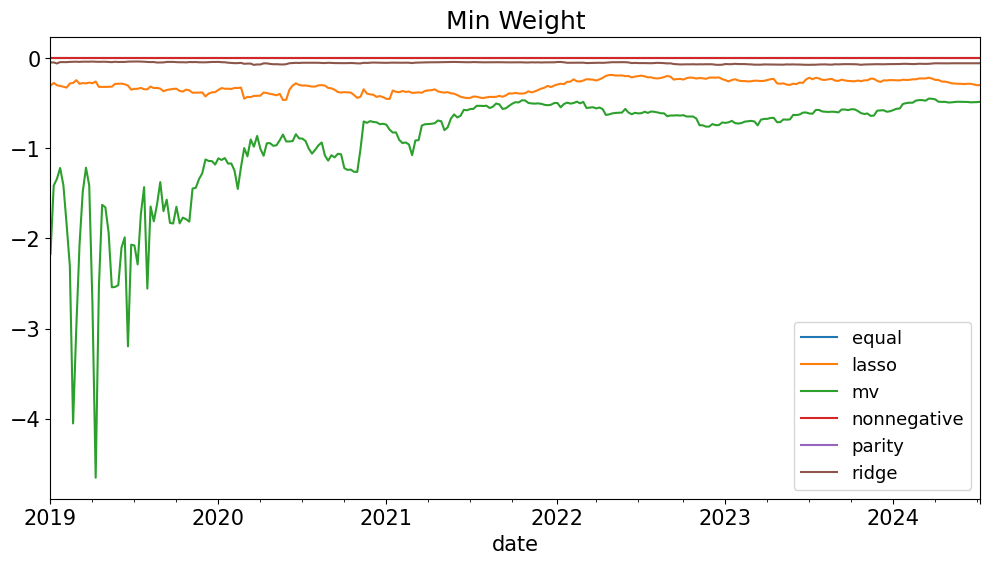

In [29]:
gross_leverage.plot(title='Gross Leverage',xlim=dates_active)
plt.ylim(0,10)
turnover.rolling(12*1).mean().plot(title='Turnover',xlim=dates_active)
plt.ylim(0,100)
plt.show()

num_positions.plot(title='Number of Positions',xlim=dates_active)
max_wt.plot(title='Max Weight',xlim=dates_active)
plt.show()
min_wt.plot(title='Min Weight',xlim=dates_active)
plt.show()